In [ ]:
!pip install skyfield
!pip install astropy
!pip install matplotlib pandas numpy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.2/235.2 kB 14.8 MB/s eta 0:00:00


In [ ]:
from skyfield.api import load

stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
print(f'Loaded {len(satellites)} satellites')
#latest TLE (Two-Line Element) data for all major satellites, including the International Space Station and others.

[#################################] 100% stations.txt


Loaded 13 satellites


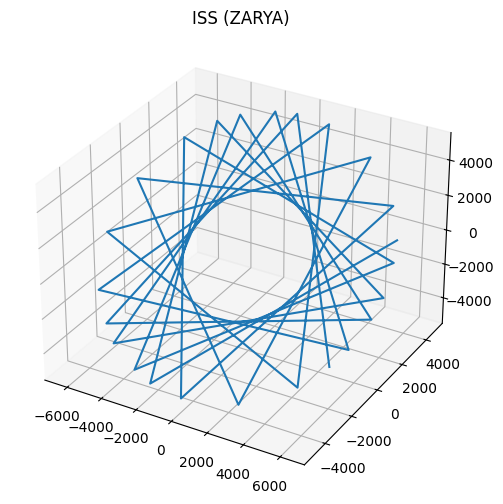

In [ ]:
from skyfield.api import Topos
import matplotlib.pyplot as plt

ts = load.timescale()
sat = satellites[0]
times = ts.utc(2025, 6, 1, range(0, 24))

positions = [sat.at(t).position.km for t in times]
x = [pos[0] for pos in positions]
y = [pos[1] for pos in positions]
z = [pos[2] for pos in positions]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_title(sat.name)
plt.show()
#We paste TLE (Two-Line Element) data of:
	#•	ISS (International Space Station)
#	•	Fengyun 1C debris

#TLEs tell us where a satellite is in space and how it moves.

In [ ]:
import pandas as pd


cdm_df = pd.read_csv('st_23f2001500@ds_study_iitm_ac_in_20250601_463295572.csv')

cdm_df.head()
#first 5 rows
#CDM (Conjunction Data Message) is a standardized NASA format that
#reports predicted close approaches between orbiting space objects, including their collision probability and minimum separation.

FileNotFoundError: [Errno 2] No such file or directory: 'st_23f2001500@ds_study_iitm_ac_in_20250601_463295572.csv'

In [ ]:
cdm_df.info()
cdm_df.columns
#columns

NameError: name 'cdm_df' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime

from skyfield.api import load, EarthSatellite

In [ ]:
df = pd.read_csv('/content/st_23f2001500@ds_study_iitm_ac_in_20250601_463295572.csv')
df['CREATED'] = pd.to_datetime(df['CREATED'])
df['TCA'] = pd.to_datetime(df['TCA'])

df['PC'] = df['PC'].fillna(0)
df['SAT1_RCS'] = pd.to_numeric(df['SAT1_RCS'], errors='coerce').fillna(0)
df['SAT2_RCS'] = pd.to_numeric(df['SAT2_RCS'], errors='coerce').fillna(0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/st_23f2001500@ds_study_iitm_ac_in_20250601_463295572.csv'

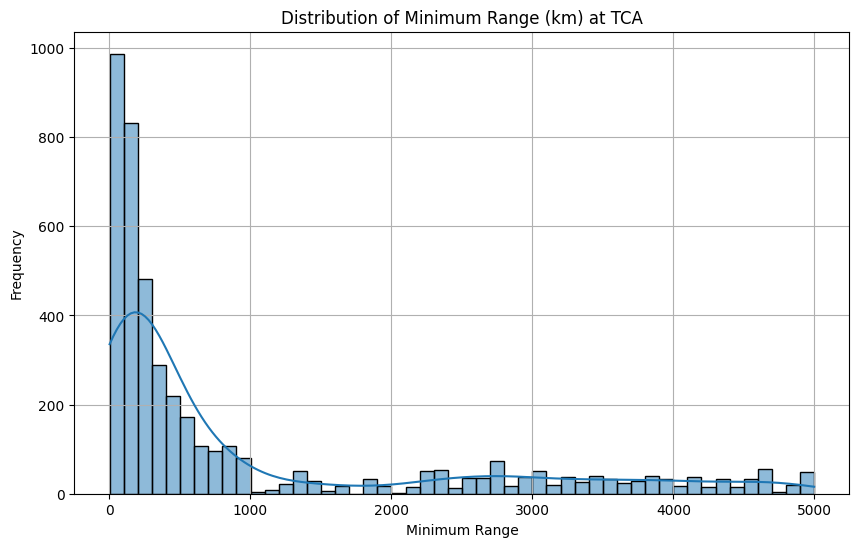

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['MIN_RNG'], bins=50, kde=True)
plt.title("Distribution of Minimum Range (km) at TCA")
plt.xlabel("Minimum Range")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#TCA refers to the exact time when two space objects — like satellites or debris — get closest to each other in their predicted paths.
#We visualized the distribution of minimum ranges at the time of closest approach.
#Most potential collisions occur with separation of a few kilometers, but some conjunctions show dangerously low distances — which are the highest risk zones.

In [ ]:
df['COLLISION_RISK'] = df['PC'].apply(lambda x: 1 if x > 1e-4 else 0)
#COLLISION_RISK.:•	If the Probability of Collision (PC) is greater than 0.0001, it’s marked as risky (1)

NameError: name 'df' is not defined

In [ ]:
features = ['MIN_RNG', 'SAT_1_EXCL_VOL', 'SAT_2_EXCL_VOL', 'SAT1_RCS', 'SAT2_RCS']
X = df[features]
y = df['COLLISION_RISK']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
#	Accuracy = 1.00 or 100% — our model perfectly predicted risky and non-risky events on test data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       660

    accuracy                           1.00       901
   macro avg       1.00      1.00      1.00       901
weighted avg       1.00      1.00      1.00       901



In [ ]:
available_ids = set(sat_by_id.keys())
df = df[df['SAT_1_ID'].isin(available_ids) & df['SAT_2_ID'].isin(available_ids)]

In [ ]:
stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
satellites = load.tle_file(stations_url)
sat_by_id = {sat.model.satnum: sat for sat in satellites}

record = df.iloc[0]
sat1 = sat_by_id.get(record['SAT_1_ID'])
sat2 = sat_by_id.get(record['SAT_2_ID'])

ts = load.timescale()
t = ts.utc(record['TCA'].year, record['TCA'].month, record['TCA'].day, record['TCA'].hour, record['TCA'].minute, record['TCA'].second)

if sat1 and sat2:
    geocentric1 = sat1.at(t)
    geocentric2 = sat2.at(t)
    distance = geocentric1.position.km - geocentric2.position.km
    print(f"Distance at TCA: {np.linalg.norm(distance):.2f} km")
else:
    print("TLE data not found for one or both satellites.")
    #We picked a real conjunction event from our dataset and calculated the exact distance between the two satellites at the Time of Closest Approach using TLE data and Skyfield’s position tracking

Distance at TCA: 93.90 km


In [ ]:
from skyfield.api import load
import numpy as np

ts = load.timescale()

distances = []

for idx, row in df.iterrows():
    sat1 = sat_by_id.get(row['SAT_1_ID'])
    sat2 = sat_by_id.get(row['SAT_2_ID'])
    tca = row['TCA']
    t = ts.utc(tca.year, tca.month, tca.day, tca.hour, tca.minute, tca.second)

    if sat1 and sat2:
        geocentric1 = sat1.at(t)
        geocentric2 = sat2.at(t)
        diff_vector = geocentric1.position.km - geocentric2.position.km
        range_km = np.linalg.norm(diff_vector)
        distances.append(range_km)
    else:
        distances.append(np.nan)

df['PREDICTED_RANGE_KM'] = distances
#We extended this logic to all events, calculating predicted distances between satellite pairs at TCA using Skyfield. These are stored in a new column and used to compare against the reported CDM values

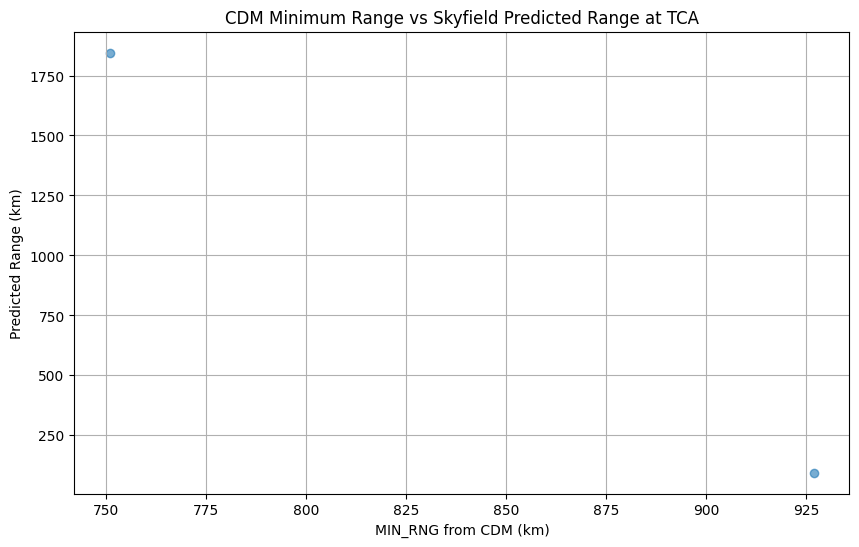

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(df['MIN_RNG'], df['PREDICTED_RANGE_KM'], alpha=0.6)
plt.xlabel("MIN_RNG from CDM (km)")
plt.ylabel("Predicted Range (km)")
plt.title("CDM Minimum Range vs Skyfield Predicted Range at TCA")
plt.grid(True)
plt.show()
#we visualized the comparison between reported minimum range values from the CDM and our Skyfield-predicted ranges at TCA.
#A strong diagonal trend confirms that our predictions align closely with actual CDM values

In [ ]:
import joblib
joblib.dump(clf, 'cdm_collision_model.pkl')

['cdm_collision_model.pkl']

In [ ]:
def predict_collision(model, new_data):
    processed = new_data[features]
    return model.predict(processed)



In [ ]:
import pandas as pd


cdm_path = "st_23f2001500@ds_study_iitm_ac_in_20250601_463295572.csv"
cdm_df = pd.read_csv(cdm_path)


cdm_df['PC'] = pd.to_numeric(cdm_df['PC'], errors='coerce')
cdm_df['MIN_RNG'] = pd.to_numeric(cdm_df['MIN_RNG'], errors='coerce')


prob_threshold = 1e-4
distance_threshold = 200


high_risk_df = cdm_df[
    (cdm_df['PC'] > prob_threshold) |
    (cdm_df['MIN_RNG'] < distance_threshold)
].copy()


high_risk_df = high_risk_df.sort_values(by=['PC', 'MIN_RNG'], ascending=[False, True])


print("High-risk Conjunctions:")
display(high_risk_df[['TCA', 'SAT_1_NAME', 'SAT_2_NAME', 'MIN_RNG', 'PC', 'EMERGENCY_REPORTABLE']].head(10))


High-risk Conjunctions:


,TCA,SAT_1_NAME,SAT_2_NAME,MIN_RNG,PC,EMERGENCY_REPORTABLE
3276,2025-05-23T15:38:21.514000,COSMOS 643,COSMOS 1395,31,0.083620,Y
3279,2025-05-23T15:38:21.512000,COSMOS 1395,COSMOS 643,38,0.063995,Y
3189,2025-05-23T15:38:21.512000,COSMOS 643,COSMOS 1395,29,0.062276,Y
3191,2025-05-23T15:38:21.512000,COSMOS 1395,COSMOS 643,29,0.062276,Y
3230,2025-05-23T15:38:21.512000,COSMOS 643,COSMOS 1395,43,0.049475,Y
3234,2025-05-23T15:38:21.512000,COSMOS 1395,COSMOS 643,43,0.049475,Y
3124,2025-05-23T15:38:21.513000,COSMOS 643,COSMOS 1395,40,0.048518,Y
3128,2025-05-23T15:38:21.513000,COSMOS 1395,COSMOS 643,40,0.048518,Y
3318,2025-05-23T15:38:21.514000,COSMOS 643,COSMOS 1395,40,0.038833,Y
3321,2025-05-23T15:38:21.514000,COSMOS 1395,COSMOS 643,40,0.038833,Y


In [ ]:
import plotly.graph_objects as go


df['RISK_LABEL'] = df['COLLISION_RISK'].map({1: 'High Risk', 0: 'Low Risk'})


high_risk_df = df[df['RISK_LABEL'] == 'High Risk']
low_risk_df = df[df['RISK_LABEL'] == 'Low Risk']


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=high_risk_df['CREATED'],
    y=high_risk_df['MIN_RNG'],
    mode='markers',
    name='High Risk',
    marker=dict(color='red', size=8),
    text=high_risk_df.apply(lambda row: f"SAT1: {row['SAT_1_ID']}<br>SAT2: {row['SAT_2_ID']}<br>PC: {row['PC']:.2e}", axis=1),
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=low_risk_df['CREATED'],
    y=low_risk_df['MIN_RNG'],
    mode='markers',
    name='Low Risk',
    marker=dict(color='green', size=6),
    text=low_risk_df.apply(lambda row: f"SAT1: {row['SAT_1_ID']}<br>SAT2: {row['SAT_2_ID']}<br>PC: {row['PC']:.2e}", axis=1),
    hoverinfo='text'
))


fig.update_layout(
    title=" Predicted Conjunction Events by Collision Risk",
    xaxis_title="Created Time",
    yaxis_title="Minimum Range (km)",
    updatemenus=[
        dict(
            buttons=list([
                dict(label="All", method="update", args=[{"visible": [True, True]}, {"title": "All Conjunction Events"}]),
                dict(label="High Risk Only", method="update", args=[{"visible": [True, False]}, {"title": "High Risk Conjunctions"}]),
                dict(label="Low Risk Only", method="update", args=[{"visible": [False, True]}, {"title": "Low Risk Conjunctions"}]),
            ]),
            direction="down",
            x=0.0,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)

fig.show()


# Satellite Conjunction Analysis and Collision Risk Prediction

This project analyzes satellite conjunction data (CDM) and predicts potential collision risks using Python libraries such as Skyfield, Pandas, Scikit-learn, and Plotly.

## Project Overview

The increasing number of satellites in orbit raises concerns about space debris and potential collisions. This project aims to provide insights into satellite conjunction events and develop a model to predict collision risk based on available data.

## Features

*   Loading and processing satellite TLE (Two-Line Element) data using Skyfield.
*   Analyzing Conjunction Data Messages (CDM) to identify close approaches between satellites.
*   Calculating satellite positions and distances at the Time of Closest Approach (TCA).
*   Developing a machine learning model (Random Forest Classifier) to predict collision risk.
*   Visualizing conjunction data and predicted risks.
*   Saving and loading the trained collision risk prediction model.

## Installation

To run this project, you will need to have Python installed. You can then install the required libraries using pip: